INFO - Input files are: EventManifest.xlsx,Budget\EventPnL.xlsx, SalesforceLatest.csv, final_regions.csv
INFO - Output files are: Budget\EventPnLProcessed.csv, DataMerge.csv
INFO - Using full dataset
INFO - Events loaded. Execution Time: 0.37
INFO - PnL data written to Budget\EventPnLProcessed.csv. Execution Time: 0.11
INFO - Starting sales size: (142082, 40)
INFO - Pruned sales size: (142073, 40)
INFO - Sales loaded. Execution Time: 1.38
INFO - Initial sales prep complete. Execution Time: 1.15
INFO - Venue and attribute processing complete. Execution Time: 0.37
INFO - Sales and events merging. Execution Time: 0.37
INFO - genre counts complete. Execution Time: 0.39
INFO - Final sales results written to file: DataMerge.csv. Execution Time: 3.44
INFO - first/last events added: Execution Time: 1.58
INFO - Bulk Buyers added: Execution Time: 0.06
INFO - Genre Scores complete. Execution Time: 3.76
INFO - Calculating RFM scores...
INFO - (19118, 14)
INFO - RFM scores complete. Execution Time:

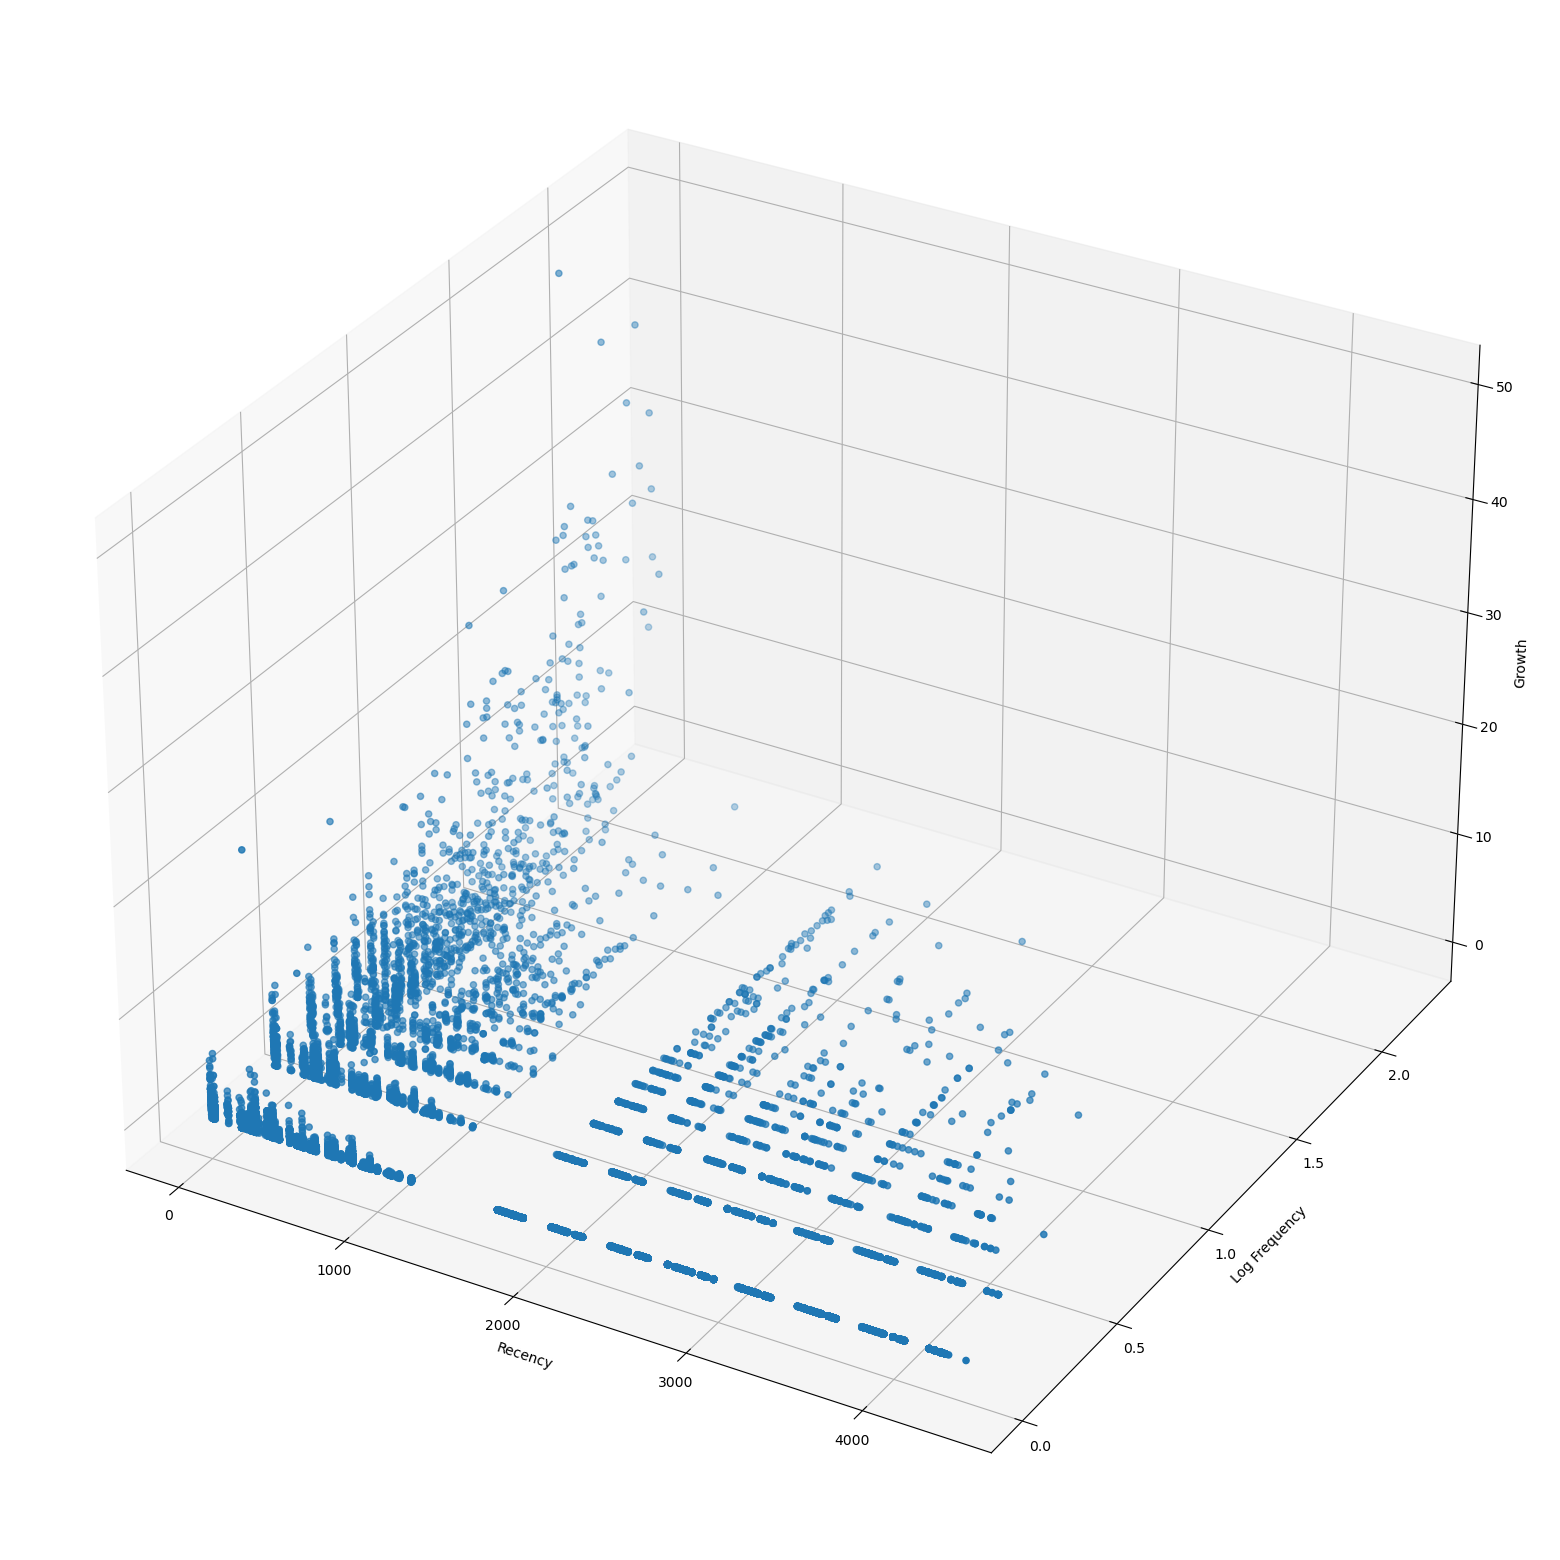

In [1]:
"""
Copyright (c) Nolichucky Associates 2024. All Rights Reserved.

This software is the confidential and proprietary information of Nolichucky Associates.
You shall not disclose such Confidential Information and shall use it only in accordance
 with the terms of the license agreement you entered into with Nolichucky Associates.

Unauthorized copying of this file, via any medium, is strictly prohibited.
Proprietary and confidential.

Project: Music Worcester Patron and Event Analytics

Author: Anthony Smith
Date: September, 2024
"""
import os
import logging
import sys
from datetime import timedelta
from timeit import default_timer as timer
from IPython.display import display
import MW_functions as mw
import Model_functions as mod

# set and change to working directory
default_data_dir = r'c:\Users\antho\WPI-MW'
#data_dir = default_data_dir
data_dir = input("Enter the name of the home directory: [WPI-MW]") or default_data_dir
os.chdir(data_dir)

# Set default logging level and update based on user input
default_log_level = 'INFO'
user_input_log_level = input("Enter logging level (DEBUG, INFO, WARNING, ERROR, CRITICAL) [INFO]: ") or default_log_level
numeric_level = getattr(logging, user_input_log_level.upper(), None)
if not isinstance(numeric_level, int):
    raise ValueError(f'Invalid log level: {user_input_log_level}')

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

if not logger.handlers:
    # Create log file handlers
    f_handler = logging.FileHandler(os.path.join(data_dir, 'sales.log'), mode='w')
    f_formatter = logging.Formatter('%(asctime)s - %(lineno)s - %(levelname)s - %(message)s')
    f_handler.setFormatter(f_formatter)
    f_handler.setLevel(logging.DEBUG)
    logger.addHandler(f_handler)

    # Create log stream handlers
    c_handler = logging.StreamHandler(sys.stdout)
    c_formatter = logging.Formatter('%(levelname)s - %(message)s')
    c_handler.setFormatter(c_formatter)
    c_handler.setLevel(numeric_level)
    logger.addHandler(c_handler)
logger.debug(f"Effective logger level: {logger.getEffectiveLevel()}")
logger.debug(f'Working directory is: {data_dir}')

# input file names
manifest_file = 'EventManifest.xlsx' # Manually created with event attributes
PnL_file = 'Budget\\EventPnL.xlsx' # Manually updated Event Profit and Loss file
default_sales_file = 'SalesforceLatest.csv' # raw Saleforce input file
AccountId_file = 'All Accounts Contacts IDs.csv' # currently not used.
chorus_file = 'FinalChorusList.csv' # List of chorus members, manually created
regions_file = 'final_regions.csv' # input file to define region mapping.

# output file names
PnLProcessed_file = 'Budget\\EventPnLProcessed.csv' # Merged event manifest and PnL data
default_output_file = 'DataMerge.csv' # full processed transaction file
output_file = default_output_file
anon_output_file = 'anon_' + output_file # anonymized form
rates_file = 'RetChurnRates.csv'

#user_output_file = input("Enter the name of the output file: ") or default_output_file7
patron_input_file = output_file # Only used to avoid regenerating Lat/Long TODO: clean this up.
patron_details_file = 'PatronDetails.csv' # output patron details
anon_patron_file = 'anon_' + patron_details_file # anonymized form

# Assign static parameters. NOTE: some of these could be reduced. 
anonymized_defaut = False
anonymized = input("Anonymize dataset? [False]") or anonymized_defaut

usps_userid = '3MUSIC10O3813'
RFMScoreThreshold = 0 # RFM score below which we don't look up lat/long
GetLatLong = True
yearsOfData = 15 # to keep
new_threshold = 250 # days since First Event for determining "New"
returning_threshold = 800 # days determining previous event for "Returning"

# Prompt the user for the sales file
sales_file = default_sales_file
#sales_file = input("Enter the name of the sales file: ") or default_sales_fil

logger.info(f'Input files are: {manifest_file},{PnL_file}, {sales_file}, {regions_file}')
logger.info(f'Output files are: {PnLProcessed_file}, {output_file}')

"""
Function: main

Description:
    This is the main function that orchestrates the processing of event, sales, and financial data. 
    It loads and processes the event manifest, merges profit and loss (PnL) data with event data, 
    processes sales data, and combines all datasets for further analysis. 
    The function also generates patron details, including venue and genre segmentation, 
    and outputs the final processed data to specified files.

Parameters:
    manifest_file (str): The file path to the event manifest Excel file.
    PnL_file (str): The file path to the Excel file containing PnL data.
    PnLProcessed_file (str): The file path where the processed PnL data will be saved as a CSV.
    sales_file (str): The file path to the Salesforce sales data CSV file.
    regions_file (str): The file path to the CSV file containing regional mapping data.
    output_file (str): The file path where the final combined and processed data will be saved as a CSV.

Process:
    1. **Load Event Manifest**: Loads event data from the manifest file.
    2. **Merge PnL Data**: Merges PnL data with event information and writes the processed PnL data to a file.
    3. **Load Sales Data**: Loads sales data from the Salesforce report.
    4. **Initial Sales Cleanup**: Performs initial cleanup on the sales data, including removing redundant data and filling missing values.
    5. **Venue and Attribute Processing**: Processes venue names and adds attributes like chorus membership, student status, and subscription status.
    6. **Merge Sales with Event Data**: Combines sales and event data to create a unified dataset.
    7. **Genre Segment Processing**: Calculates genre preferences and other segments for each account.
    8. **Final Processing and Output**: Cleans up the combined dataset and writes the final processed data to an output file.
    9. **Generate Patron Details**: Generates detailed patron data, including RFM scores and segment assignments, and writes this to the specified file.

Returns:
    None: The processed data is written to the specified output files.

Exceptions:
    - Catches any exceptions during the execution and logs them.
"""
def main(manifest_file,
         PnL_file,
         PnLProcessed_file,
         sales_file, # Updated52
         regions_file,
         output_file): # Updated

    if anonymized != True:
        logger.info(f'Using full dataset')

        # Load event manifest containing event attributes
        logger.debug(f'Loading events data')
        event_df = mw.load_event_manifest(manifest_file, 
                                          logger)
    
        # Merge PnL data with manifest and write out PnL_Processed file.
        logger.debug(f'Processing PnL data')
        event_df = mw.add_PnL_data(event_df,
                                   PnL_file,
                                   PnLProcessed_file,
                                   logger)
    
        # Load sales data from Salesforce report
        sales_df = mw.load_sales_file(sales_file, 
                                      yearsOfData, 
                                      logger)
        
        # Initial cleanup of Salesforce data
        sales_df = mw.sales_initial_prep(sales_df,
                                         AccountId_file, 
                                         logger)
    
        # Determine venue and intial segments
        sales_df = mw.venue_and_attribute_processing(sales_df, 
                                                     chorus_file, 
                                                     logger)
        
        # Merge sales with event attributes
        sales_events_df = mw.combine_sales_and_events(sales_df, 
                                                  event_df, 
                                                  logger)
    
        # Determine genre counts
        sales_events_df = mw.genre_counts(sales_events_df, 
                                                  logger)
    
        # Final cleanup and write output file
        sales_events_df = mw.final_processing_and_output(sales_events_df, 
                                                     output_file, 
                                                     logger, 
                                                     processDonations = True)
    else:
        logger.info(f'Using anonymized dataset')
        sales_events_df= mw.load_anonymized_dataset(anon_output_file, logger)

    rates_df = mw.calculate_retention_and_churn(sales_events_df,logger)
    rates_df.to_csv(rates_file)
            
    # Final write patron details file
    patrons_df = mw.get_patron_details(sales_events_df,
                                       rates_df,
                                       RFMScoreThreshold,
                                       GetLatLong,
                                       regions_file,
                                       patron_details_file,
                                       anonymized,
                                       new_threshold,
                                       returning_threshold,
                                       logger)
    
#main program
try:
    start = timer()
    if __name__ == '__main__':
        
        main(manifest_file,
             PnL_file,
             PnLProcessed_file,
             sales_file,
             regions_file,
             output_file)
    end = timer()
    timing = timedelta(seconds=(end-start))
    formatted_timing = "{:.2f}".format(timing.total_seconds())
    print(f'Success. Total Time: {formatted_timing}')

except Exception as e:
    logger.error(f'Exception caught: {e}')